In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import schedulefree

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys

sys.path.append("../auto_LiRPA/")
import auto_LiRPA
from auto_LiRPA.operators.gurobi_maxpool_lp import compute_maxpool_bias

Since solving a series of linear programs for every unstable MaxPool neuron takes a prohibitive amount of time, we want to learn a neural network to approximate the optimal value of the series of linear programs.

Subsequently, we want to verify that network, so it can be used instead of the LPs.

# Idea

To allow the NN to learn the LP solutions for globally valid parameters of
- lower bounds
- upper bounds and
- slope values

we **normalize the bounds** to $[0,1]$, s.t. the smallest lower bound gets mapped to $0$ and the largest upper bound gets mapped to $1$.
Similarly, we restrict the allowable slope values to $[0,1]$ (**TODO**: Show that this is sufficient for MaxPool).

## 2x2 MaxPool

We start with the easier case of lower dimensional MaxPool neurons.

In [8]:
# (batch, channels, w, h), we only look at a single neuron for now
l = torch.randn(1, 1, 2, 2)
u = torch.abs(torch.randn(1, 1, 2, 2)) + l
alpha = torch.rand(1, 1, 2, 2)

print("l = ", l)
print("u = ", u)

l =  tensor([[[[ 0.3786, -0.1183],
          [-0.6204,  0.1453]]]])
u =  tensor([[[[ 0.9778,  0.7224],
          [-0.2365,  2.6166]]]])


In [9]:
compute_maxpool_bias(l, u, alpha)

100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


tensor([[0.9637]])

In [10]:
# now for a lot of neurons
n_neurons = 100
l = torch.randn(n_neurons, 1, 2, 2)
u = torch.abs(torch.randn(n_neurons, 1, 2, 2)) + l
alpha = torch.rand(n_neurons, 1, 2, 2)

biases = compute_maxpool_bias(l, u, alpha)

100%|██████████| 100/100 [00:00<00:00, 188.14it/s]


In [40]:
lmin = l.flatten(-2).min(dim=-1)[0]
umax = u.flatten(-2).max(dim=-1)[0]

lmin = lmin.unsqueeze(1)
umax = umax.unsqueeze(1)

In [49]:
l_norm = (l.flatten(-2) - lmin) / (umax - lmin)
u_norm = (u.flatten(-2) - lmin) / (umax - lmin)
l_norm = l_norm.view(l.shape)
u_norm = u_norm.view(u.shape)

In [51]:
biases_norm = compute_maxpool_bias(l_norm, u_norm, alpha)

100%|██████████| 100/100 [00:00<00:00, 207.94it/s]


In [68]:
biases_unnorm = biases_norm.unsqueeze(1) * (umax - lmin) - (alpha.flatten(-2).sum(dim=-1) - 1).unsqueeze(1) * lmin
biases_unnorm = biases_unnorm.squeeze(1)

The error falls within the `float32` range.

So normalization seems to work :-)

In [70]:
torch.max(torch.abs(biases_unnorm - biases))

tensor(9.5367e-07)

## Normalization: Now in a Single Method

In [2]:
def normalize_bounds(l, u):
    """
    Takes bounds tensors and normalizes them to [0, 1], s.t. smallest lower bound is mapped to 0
    and largest upper bound is mapped to 1

    args:
        l (batch x channels x w x h) - concrete lower bounds
        u (batch x channels x w x h) - concrete upper bounds

    returns:
        l_norm (batch x channels x w x h) - normalized concrete lower bounds
        u_norm (batch x channels x w x h) - normalized concrete upper bounds
    """
    lmin = l.flatten(-2).min(dim=-1)[0]
    umax = u.flatten(-2).max(dim=-1)[0]
    lmin = lmin.unsqueeze(1)
    umax = umax.unsqueeze(1)

    l_norm = (l.flatten(-2) - lmin) / (umax - lmin)
    u_norm = (u.flatten(-2) - lmin) / (umax - lmin)
    l_norm = l_norm.view(l.shape)
    u_norm = u_norm.view(u.shape)

    return l_norm, u_norm

In [3]:
def denormalize_bias(l, u, alpha, bias):
    """ 
    Converts biases obtained from the normalized problem to the biases for the unnormalized problem.

    args:
        l (batch x channels x w x h) - unnormalized concrete lower bounds
        u (batch x channels x w x h) - unnormalized concrete upper bounds
        alpha (batch x channels x w x h) - slope values
        bias (batch x channels) - normalized bias values

    returns:
        bias_unnorm (batch x channels) - biases for unnormalized problem
    """
    lmin = l.flatten(-2).min(dim=-1)[0]
    umax = u.flatten(-2).max(dim=-1)[0]
    lmin = lmin.unsqueeze(1)
    umax = umax.unsqueeze(1)

    biases_unnorm = bias.unsqueeze(1) * (umax - lmin) - (alpha.flatten(-2).sum(dim=-1) - 1).unsqueeze(1) * lmin
    biases_unnorm = biases_unnorm.squeeze(1)

    return biases_unnorm

## Create Dataset

In [4]:
def sort_by_lower_bound(X):
    """
    Sorts tensor of shape (n_neurons, 3, w, h) by concrete lower bounds (the first channel dim).
    """
    _, ind_tensor = X.flatten(-2)[:,0].sort(dim=-1)
    ind_tensor = ind_tensor.unsqueeze(1).expand(-1, X.size(1), -1)

    return torch.gather(X.flatten(-2), dim=2, index=ind_tensor).view(X.shape)

In [5]:
def create_dataset(n_neurons, h, w):
    # since the normalized version suffices, just stick to that
    x1 = torch.rand(n_neurons, 1, h, w)
    x2 = torch.rand(n_neurons, 1, h, w)

    l = torch.where(x1 <= x2, x1, x2)
    u = torch.where(x1  > x2, x1, x2)

    alpha = torch.rand(n_neurons, 1, h, w)

    biases = compute_maxpool_bias(l, u, alpha)

    return l, u, alpha, biases

In [6]:
def create_tensor_dataset(n_neurons_train, n_neurons_val, h, w, sort_by_lb=False):
    l, u, alpha, bias = create_dataset(n_neurons_train, h, w)
    X = torch.cat((l, u, alpha), dim=1)
    dataset_train = TensorDataset(X, bias)

    l, u, alpha, bias = create_dataset(n_neurons_val, h, w)
    X = torch.cat((l, u, alpha), dim=1)

    if sort_by_lb:
        X = sort_by_lower_bound(X)
        
    dataset_val = TensorDataset(X, bias)

    return dataset_train, dataset_val

In [137]:
batch_size = 32
n_train = 50000
n_val = 5000

ds_train, ds_val = create_tensor_dataset(n_train, n_val, 2, 2)
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(ds_val, batch_size=batch_size)

100%|██████████| 5000/5000 [00:32<00:00, 155.86it/s]


## Load Saved Datasets

In [ ]:
torch.save(ds_train, './datasets/maxpool2x2_train.pth')
torch.save(ds_val, './datasets/maxpool2x2_val.pth')

# datasets can then be loaded via
# ds_train = torch.load('./datasets/maxpool2x2_train.pth')
# ds_val   = torch.load('./datasets/maxpool2x2_val.pth')

In [315]:
batch_size = 32
n_train = 100000
n_val = 10000

ds_train, ds_val = create_tensor_dataset(n_train, n_val, 2, 2)
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(ds_val, batch_size=batch_size)

torch.save(ds_train, './datasets/maxpool2x2_train_100k.pth')
torch.save(ds_val, './datasets/maxpool2x2_val_100k.pth')

100%|██████████| 10000/10000 [01:04<00:00, 154.97it/s]


In [147]:
ds_train = torch.load('./datasets/maxpool2x2_train.pth')
ds_val   = torch.load('./datasets/maxpool2x2_val.pth')

In [148]:
X, y = ds_train[:]
X = sort_by_lower_bound(X)

ds_train_sorted = TensorDataset(X, y)

X, y = ds_val[:]
X = sort_by_lower_bound(X)

ds_val_sorted = TensorDataset(X, y)

torch.save(ds_train, './datasets/maxpool2x2_train_100k_sorted.pth')
torch.save(ds_val, './datasets/maxpool2x2_val_100k_sorted.pth')

In [159]:
batch_size = 32
train_dataloader = DataLoader(ds_train_sorted, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(ds_val_sorted, batch_size=batch_size)

# Inspect Datasets

In [142]:
X, y = ds_train[:]

/tmp/ipykernel_1272528/2670862516.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


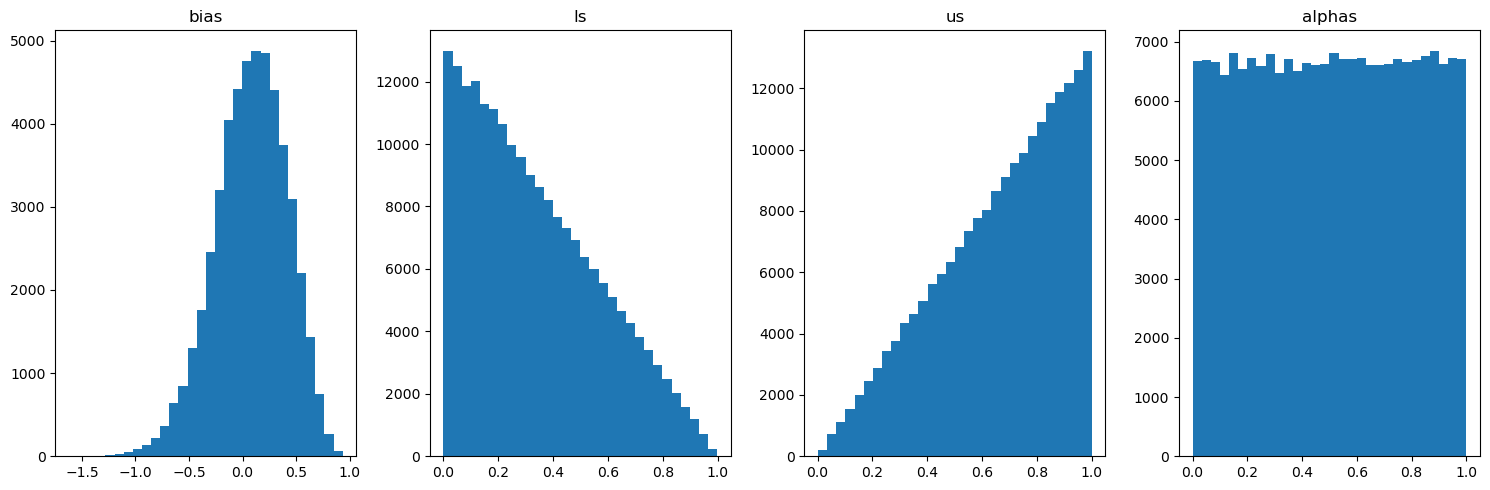

In [23]:
ls = X[:,0,:,:].reshape(-1).numpy()
us = X[:,1,:,:].reshape(-1).numpy()
alphas = X[:,2,:,:].reshape(-1).numpy()

fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 5))

ax[0].hist(y.numpy().reshape(-1), bins=30)
ax[0].title.set_text('bias')

ax[1].hist(ls, bins=30)
ax[1].title.set_text('ls')

ax[2].hist(us, bins=30)
ax[2].title.set_text('us')

ax[3].hist(alphas, bins=30)
ax[3].title.set_text('alphas')
fig.show()

/tmp/ipykernel_1272528/4006828585.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


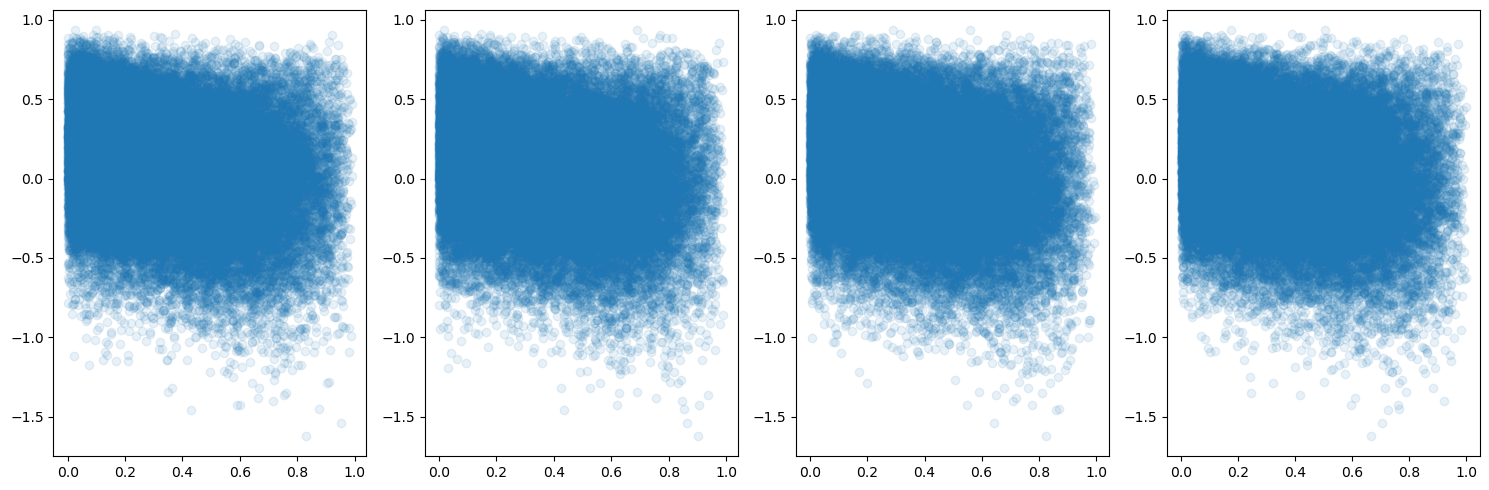

In [29]:
fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 5))

ax[0].scatter(X[:,0,0,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[1].scatter(X[:,0,0,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[2].scatter(X[:,0,1,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[3].scatter(X[:,0,1,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)

fig.show()

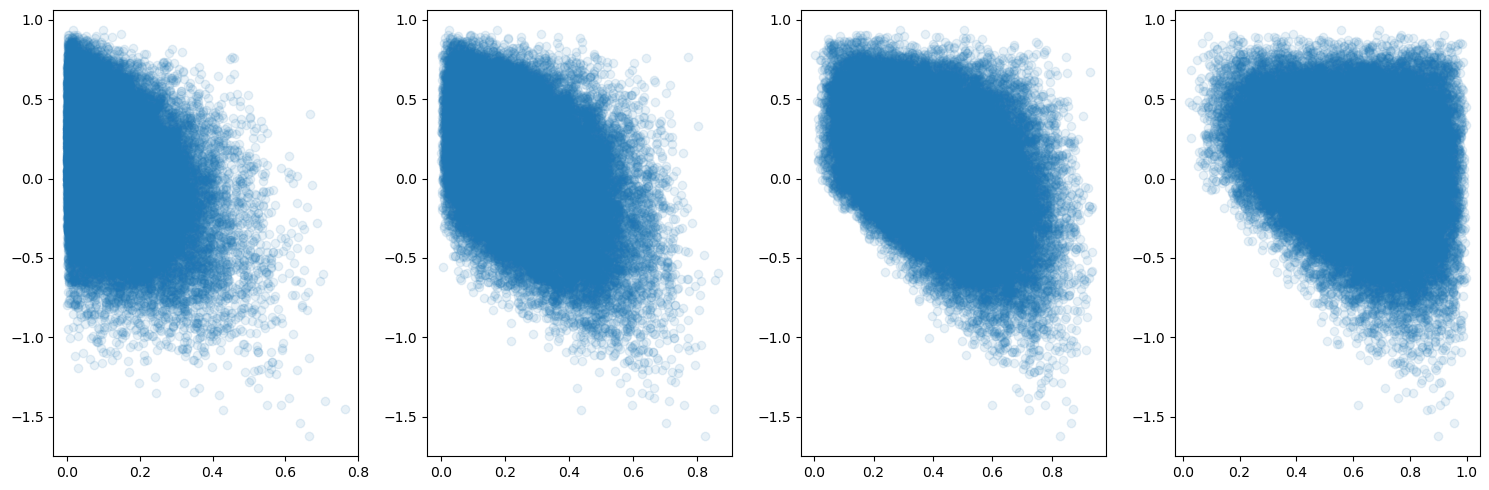

In [143]:
fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 5))

X = sort_by_lower_bound(X)

ax[0].scatter(X[:,0,0,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[1].scatter(X[:,0,0,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[2].scatter(X[:,0,1,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[3].scatter(X[:,0,1,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)

/tmp/ipykernel_1272528/1829589722.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


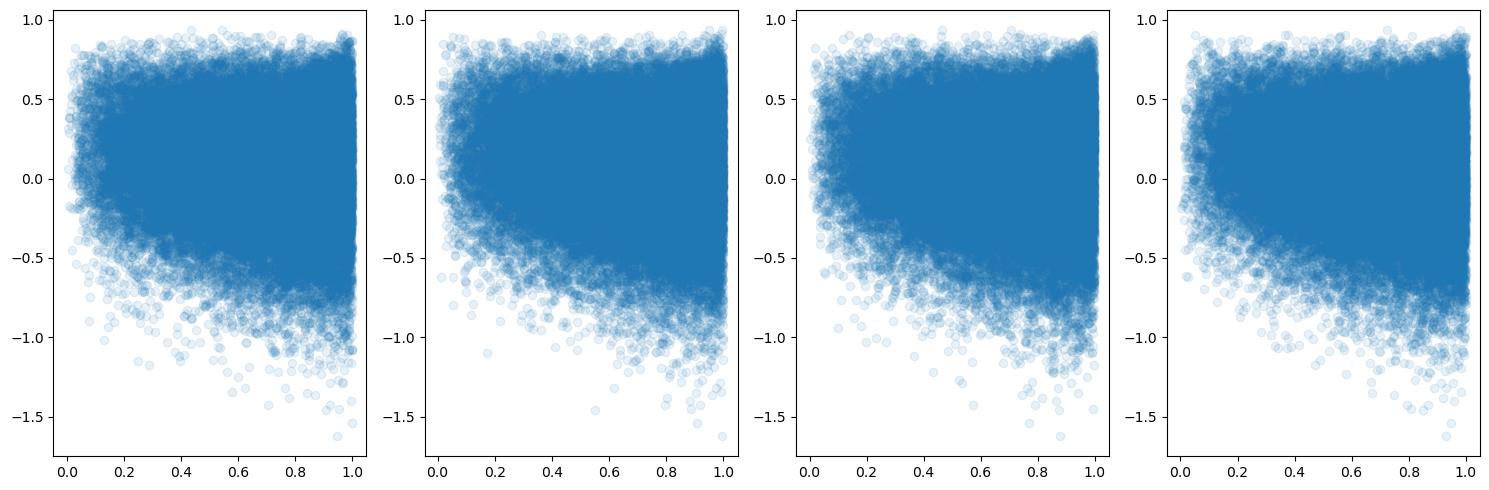

In [30]:
fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 5))

ax[0].scatter(X[:,1,0,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[1].scatter(X[:,1,0,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[2].scatter(X[:,1,1,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[3].scatter(X[:,1,1,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)

fig.show()

/tmp/ipykernel_1272528/1829589722.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


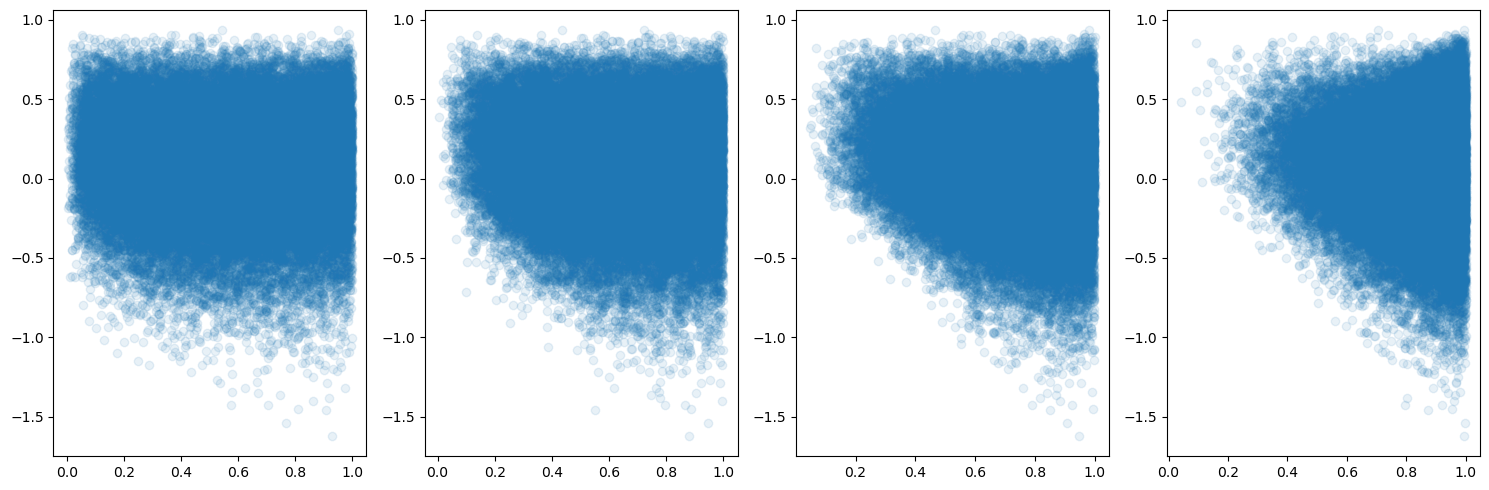

In [ ]:
# now with X sorted by lower bound
fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 5))

ax[0].scatter(X[:,1,0,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[1].scatter(X[:,1,0,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[2].scatter(X[:,1,1,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[3].scatter(X[:,1,1,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)

fig.show()

/tmp/ipykernel_1272528/3666492864.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


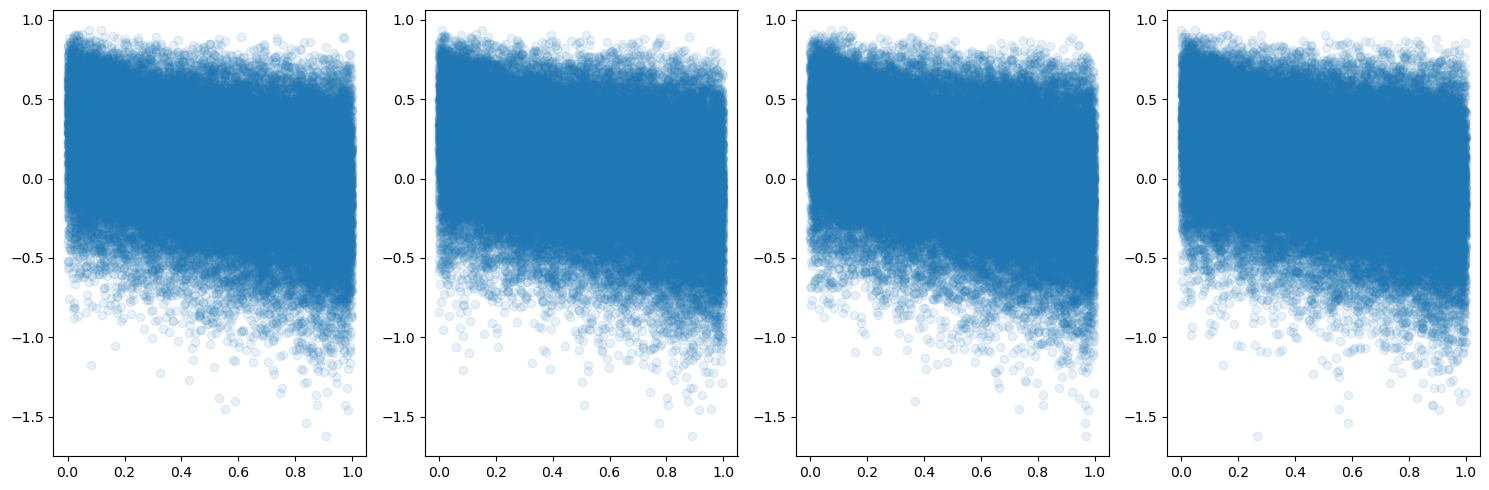

In [31]:
fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 5))

ax[0].scatter(X[:,2,0,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[1].scatter(X[:,2,0,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[2].scatter(X[:,2,1,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[3].scatter(X[:,2,1,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)

fig.show()

/tmp/ipykernel_1272528/3666492864.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


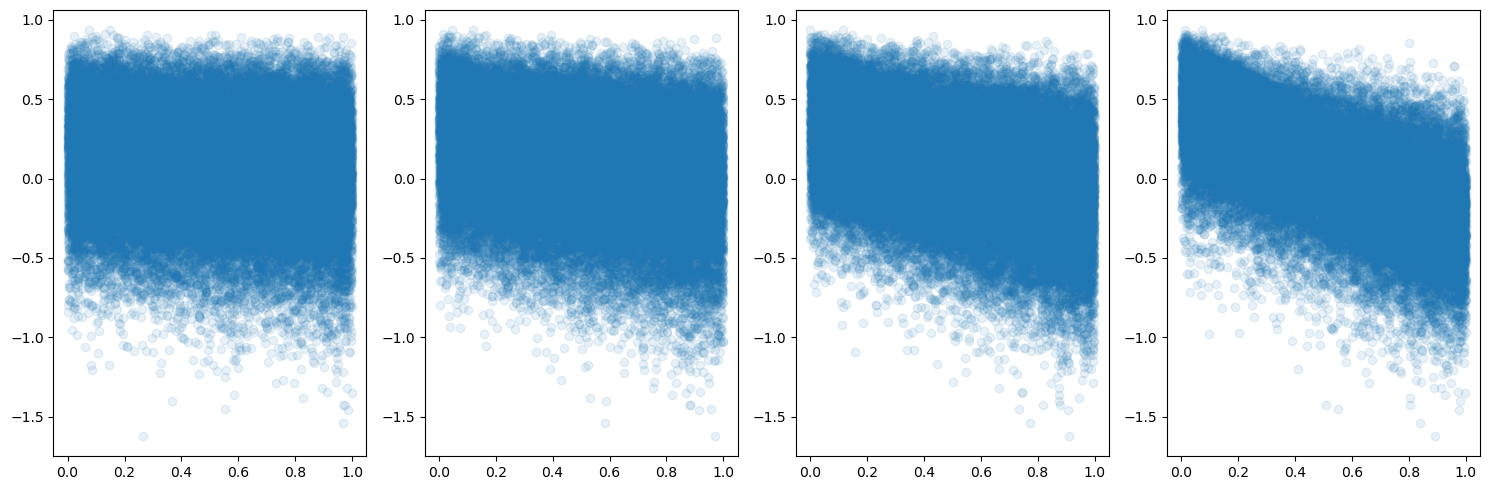

In [ ]:
# now with X sorted by lower bound
fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 5))

ax[0].scatter(X[:,2,0,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[1].scatter(X[:,2,0,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[2].scatter(X[:,2,1,0].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)
ax[3].scatter(X[:,2,1,1].numpy().reshape(-1), y.numpy().reshape(-1), alpha=0.1)

fig.show()

In [32]:
ds_train[0]

(tensor([[[0.7138, 0.2893],
          [0.5006, 0.1497]],
 
         [[0.9137, 0.3436],
          [0.7011, 0.7816]],
 
         [[0.5361, 0.0492],
          [0.3276, 0.7446]]]),
 tensor([0.1342]))

In [ ]:
ls = ds_train[0][0][0].view(-1)
us = ds_train[0][0][1].view(-1)
alphas = ds_train[0][0][2].view(-1)
x = torch.rand(alphas.size())

bias = ds_train[0][1]
bias

tensor([0.1342])

In [78]:
def test_correct_bias(ls, us, alphas, bias):
    x = torch.rand(ls.size())
    x = ls + (us - ls)*x

    errs = alphas @ x + bias[0] - x
    if any(errs < 0):
        print(errs)
        #print(f"ls     = ", ls)
        #print(f"us     = ", us)
        #print(f"x      = ", x)
        #print(f"alphas = ", alphas)
        #print(f"bias   = ", bias)

    return torch.min(errs)

In [140]:
sort_by_lower_bound(X).flatten(-2)

tensor([[[0.1497, 0.2893, 0.5006, 0.7138],
         [0.7816, 0.3436, 0.7011, 0.9137],
         [0.7446, 0.0492, 0.3276, 0.5361]],

        [[0.1941, 0.2054, 0.4997, 0.5515],
         [0.5241, 0.2872, 0.7329, 0.8701],
         [0.5912, 0.0090, 0.4072, 0.0040]],

        [[0.1478, 0.1992, 0.5086, 0.5244],
         [0.5849, 0.6364, 0.5846, 0.9471],
         [0.4995, 0.8868, 0.6294, 0.8649]],

        [[0.3597, 0.4681, 0.5324, 0.6370],
         [0.5903, 0.4989, 0.5849, 0.6774],
         [0.2206, 0.6522, 0.0239, 0.6285]],

        [[0.2109, 0.3265, 0.3772, 0.5160],
         [0.7914, 0.8622, 0.8274, 0.9978],
         [0.8497, 0.9303, 0.0900, 0.8488]],

        [[0.2436, 0.3575, 0.5111, 0.6002],
         [0.9890, 0.9727, 0.5927, 0.8135],
         [0.4204, 0.8316, 0.7063, 0.8368]],

        [[0.0157, 0.0562, 0.1132, 0.3440],
         [0.1498, 0.1059, 0.4054, 0.6323],
         [0.9842, 0.7767, 0.9074, 0.3515]],

        [[0.0581, 0.2224, 0.4912, 0.5354],
         [0.6483, 0.3633, 0.6731, 0.8821

In [104]:
n_test = 10
ls, us, alphas, biases = create_dataset(n_test, 2, 2)

for i in range(n_test):
    l = ls[i,0,:,:].view(-1)
    u = us[i,0,:,:].view(-1)
    alpha = alphas[i,0,:,:].view(-1)
    bias = biases[i,:]
    
    errmin = test_correct_bias(l, u, alpha, bias)

    if errmin < 0:
        print(f"ls     = ", ls)
        print(f"us     = ", us)
        print(f"alphas = ", alphas)
        print(f"bias   = ", bias)

    print(errmin)

100%|██████████| 10/10 [00:00<00:00, 116.01it/s]

tensor(0.3397)
tensor(0.1403)
tensor(0.3428)
tensor(0.1218)
tensor(0.3767)
tensor(0.1281)
tensor(0.1330)
tensor(0.5350)
tensor(0.6979)
tensor(0.2087)


In [100]:
ds_train[0][1]

tensor([0.1342])

In [102]:
for i in range(1000):
    ls = ds_train[i][0][0].view(-1)
    us = ds_train[i][0][1].view(-1)
    alphas = ds_train[i][0][2].view(-1)
    bias = ds_train[i][1]
    test_correct_bias(ls, us, alphas, bias)

# Training Loop

In [7]:
def train_loop(net, train_dataloader, val_dataloader, patience=10, num_epochs=100, lossfun='mse', opt='adam'):
    if lossfun == 'mse':
        criterion = nn.MSELoss()
    elif lossfun == 'mae':
        criterion = nn.L1Loss()
    else:
        raise ValueError('Unknown loss function!')
    
    if opt == 'adam':
        optimizer = optim.Adam(net.parameters())
    elif opt == 'schedulefree':
        optimizer = schedulefree.AdamWScheduleFree(net.parameters(), lr=0.0025)
    else:
        raise ValueError('Uknown optimizer!')


    train_losses = []
    train_maes = []
    val_losses = []
    val_maes = []
    best_val_loss = float('inf')
    early_stopping_cnt = 0
    for epoch in range(num_epochs):
        net.train()

        if opt == 'schedulefree':
            optimizer.train()

        train_loss = 0.
        train_mae = 0.
        for batch_X, batch_y in train_dataloader:
            y_hat = net(batch_X)
            loss = criterion(y_hat, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(y_hat - batch_y).mean().item()

        train_loss /= len(train_dataloader)
        train_mae /= len(train_dataloader)
        train_losses.append(train_loss)
        train_maes.append(train_mae)


        net.eval()

        if opt == 'schedulefree':
            optimizer.eval()
            
        val_loss = 0
        val_mae = 0
        with torch.no_grad():
            for batch_X, batch_y in val_dataloader:
                y_hat = net(batch_X)
                loss = criterion(y_hat, batch_y)
                val_loss += loss.item()
                val_mae += torch.abs(y_hat - batch_y).mean().item()

        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_mae: {train_mae:.4f}, val_mae: {val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_cnt = 0
            best_net_state = net.state_dict()
        else:
            early_stopping_cnt += 1
            if early_stopping_cnt >= patience:
                print(f"Stopping early (patience of {patience} reached)")
                break


    print("Training completed")
    return train_losses, val_losses, train_maes, val_maes, best_net_state

In [131]:
net1x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))

In [138]:
train_losses1x30, val_losses1x30, train_maes1x30, val_maes1x30, best_state1x30 = train_loop(net1x30, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0024, val_loss: 0.0027, train_mae: 0.0390, val_mae: 0.0414
Epoch [2/1000] - train_loss: 0.0024, val_loss: 0.0024, train_mae: 0.0383, val_mae: 0.0386
Epoch [3/1000] - train_loss: 0.0024, val_loss: 0.0023, train_mae: 0.0382, val_mae: 0.0376
Epoch [4/1000] - train_loss: 0.0023, val_loss: 0.0023, train_mae: 0.0376, val_mae: 0.0376
Epoch [5/1000] - train_loss: 0.0023, val_loss: 0.0023, train_mae: 0.0377, val_mae: 0.0379
Epoch [6/1000] - train_loss: 0.0023, val_loss: 0.0022, train_mae: 0.0374, val_mae: 0.0364
Epoch [7/1000] - train_loss: 0.0022, val_loss: 0.0022, train_mae: 0.0372, val_mae: 0.0364
Epoch [8/1000] - train_loss: 0.0022, val_loss: 0.0023, train_mae: 0.0371, val_mae: 0.0372
Epoch [9/1000] - train_loss: 0.0022, val_loss: 0.0022, train_mae: 0.0370, val_mae: 0.0368
Epoch [10/1000] - train_loss: 0.0022, val_loss: 0.0024, train_mae: 0.0366, val_mae: 0.0389
Epoch [11/1000] - train_loss: 0.0021, val_loss: 0.0022, train_mae: 0.0363, val_mae: 0.0366
Epoch [1

In [139]:
train_losses2x30, val_losses2x30, train_maes2x30, val_maes2x30, best_state2x30 = train_loop(net2x30, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0252, val_mae: 0.0249
Epoch [2/1000] - train_loss: 0.0010, val_loss: 0.0015, train_mae: 0.0249, val_mae: 0.0313
Epoch [3/1000] - train_loss: 0.0010, val_loss: 0.0009, train_mae: 0.0243, val_mae: 0.0237
Epoch [4/1000] - train_loss: 0.0009, val_loss: 0.0010, train_mae: 0.0240, val_mae: 0.0246
Epoch [5/1000] - train_loss: 0.0009, val_loss: 0.0010, train_mae: 0.0238, val_mae: 0.0248
Epoch [6/1000] - train_loss: 0.0009, val_loss: 0.0009, train_mae: 0.0237, val_mae: 0.0228
Epoch [7/1000] - train_loss: 0.0009, val_loss: 0.0008, train_mae: 0.0230, val_mae: 0.0220
Epoch [8/1000] - train_loss: 0.0009, val_loss: 0.0010, train_mae: 0.0229, val_mae: 0.0252
Epoch [9/1000] - train_loss: 0.0008, val_loss: 0.0008, train_mae: 0.0228, val_mae: 0.0214
Epoch [10/1000] - train_loss: 0.0008, val_loss: 0.0008, train_mae: 0.0227, val_mae: 0.0218
Epoch [11/1000] - train_loss: 0.0008, val_loss: 0.0008, train_mae: 0.0225, val_mae: 0.0220
Epoch [1

In [140]:
train_losses3x30, val_losses3x30, train_maes3x30, val_maes3x30, best_state3x30 = train_loop(net3x30, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0012, val_loss: 0.0013, train_mae: 0.0273, val_mae: 0.0287
Epoch [2/1000] - train_loss: 0.0012, val_loss: 0.0012, train_mae: 0.0268, val_mae: 0.0269
Epoch [3/1000] - train_loss: 0.0011, val_loss: 0.0011, train_mae: 0.0262, val_mae: 0.0261
Epoch [4/1000] - train_loss: 0.0011, val_loss: 0.0010, train_mae: 0.0262, val_mae: 0.0245
Epoch [5/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0252, val_mae: 0.0251
Epoch [6/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0252, val_mae: 0.0241
Epoch [7/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0247, val_mae: 0.0240
Epoch [8/1000] - train_loss: 0.0010, val_loss: 0.0012, train_mae: 0.0245, val_mae: 0.0266
Epoch [9/1000] - train_loss: 0.0010, val_loss: 0.0009, train_mae: 0.0244, val_mae: 0.0235
Epoch [10/1000] - train_loss: 0.0009, val_loss: 0.0009, train_mae: 0.0238, val_mae: 0.0228
Epoch [11/1000] - train_loss: 0.0009, val_loss: 0.0012, train_mae: 0.0237, val_mae: 0.0285
Epoch [1

In [155]:
net_conv = torch.nn.Sequential(torch.nn.Conv2d(3, 100, 2), torch.nn.ReLU(), torch.nn.Flatten(), torch.nn.Linear(100, 50), torch.nn.ReLU(), torch.nn.Linear(50, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))

In [160]:
train_losses_conv, val_losses_conv, train_maes_conv, val_maes_conv, best_state_conv = train_loop(net_conv, train_dataloader, val_dataloader, patience=50, num_epochs=100)

Epoch [1/100] - train_loss: 0.0074, val_loss: 0.0018, train_mae: 0.0561, val_mae: 0.0326
Epoch [2/100] - train_loss: 0.0016, val_loss: 0.0011, train_mae: 0.0307, val_mae: 0.0250
Epoch [3/100] - train_loss: 0.0010, val_loss: 0.0014, train_mae: 0.0247, val_mae: 0.0293
Epoch [4/100] - train_loss: 0.0008, val_loss: 0.0013, train_mae: 0.0219, val_mae: 0.0296
Epoch [5/100] - train_loss: 0.0007, val_loss: 0.0006, train_mae: 0.0203, val_mae: 0.0186
Epoch [6/100] - train_loss: 0.0007, val_loss: 0.0005, train_mae: 0.0196, val_mae: 0.0170
Epoch [7/100] - train_loss: 0.0006, val_loss: 0.0004, train_mae: 0.0187, val_mae: 0.0160
Epoch [8/100] - train_loss: 0.0005, val_loss: 0.0004, train_mae: 0.0176, val_mae: 0.0153
Epoch [9/100] - train_loss: 0.0005, val_loss: 0.0004, train_mae: 0.0171, val_mae: 0.0150
Epoch [10/100] - train_loss: 0.0004, val_loss: 0.0004, train_mae: 0.0162, val_mae: 0.0142
Epoch [11/100] - train_loss: 0.0004, val_loss: 0.0004, train_mae: 0.0155, val_mae: 0.0152
Epoch [12/100] - tr

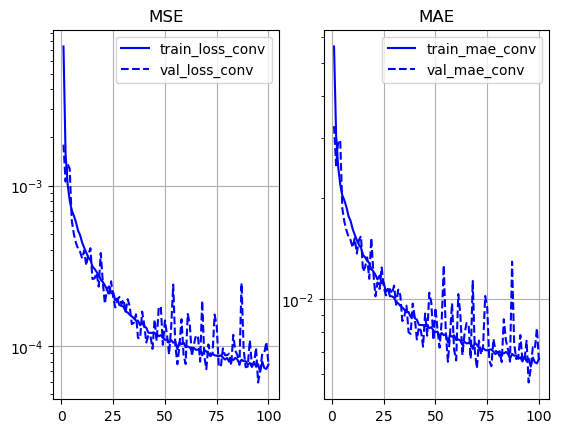

In [161]:
num_epochs_conv = len(train_losses_conv)

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_conv+1), train_losses_conv, label="train_loss_conv", color='blue')
plt.plot(range(1, num_epochs_conv+1), val_losses_conv, label="val_loss_conv", color='blue', linestyle='--')

plt.title("MSE")
plt.yscale('log')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_conv+1), train_maes_conv, label="train_mae_conv", color='blue')
plt.plot(range(1, num_epochs_conv+1), val_maes_conv, label="val_mae_conv", color='blue', linestyle='--')

plt.title("MAE")
plt.yscale('log')
plt.grid(True)
plt.legend()

plt.show()

In [148]:
net6x50 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))

In [149]:
train_losses6x50, val_losses6x50, train_maes6x50, val_maes6x50, best_state6x50 = train_loop(net6x50, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0123, val_loss: 0.0032, train_mae: 0.0737, val_mae: 0.0450
Epoch [2/1000] - train_loss: 0.0029, val_loss: 0.0029, train_mae: 0.0425, val_mae: 0.0423
Epoch [3/1000] - train_loss: 0.0022, val_loss: 0.0020, train_mae: 0.0372, val_mae: 0.0359
Epoch [4/1000] - train_loss: 0.0018, val_loss: 0.0018, train_mae: 0.0328, val_mae: 0.0335
Epoch [5/1000] - train_loss: 0.0015, val_loss: 0.0012, train_mae: 0.0304, val_mae: 0.0266
Epoch [6/1000] - train_loss: 0.0013, val_loss: 0.0012, train_mae: 0.0286, val_mae: 0.0279
Epoch [7/1000] - train_loss: 0.0012, val_loss: 0.0011, train_mae: 0.0269, val_mae: 0.0262
Epoch [8/1000] - train_loss: 0.0011, val_loss: 0.0009, train_mae: 0.0255, val_mae: 0.0241
Epoch [9/1000] - train_loss: 0.0010, val_loss: 0.0014, train_mae: 0.0246, val_mae: 0.0302
Epoch [10/1000] - train_loss: 0.0009, val_loss: 0.0009, train_mae: 0.0237, val_mae: 0.0242
Epoch [11/1000] - train_loss: 0.0009, val_loss: 0.0008, train_mae: 0.0233, val_mae: 0.0223
Epoch [1

In [164]:
net6x50mae = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))

In [165]:
train_losses6x50mae, val_losses6x50mae, train_maes6x50mae, val_maes6x50mae, best_state6x50mae = train_loop(net6x50mae, train_dataloader, val_dataloader, patience=50, num_epochs=1000, lossfun='mae')

Epoch [1/1000] - train_loss: 0.0779, val_loss: 0.0554, train_mae: 0.0779, val_mae: 0.0554
Epoch [2/1000] - train_loss: 0.0441, val_loss: 0.0393, train_mae: 0.0441, val_mae: 0.0393
Epoch [3/1000] - train_loss: 0.0385, val_loss: 0.0406, train_mae: 0.0385, val_mae: 0.0406
Epoch [4/1000] - train_loss: 0.0346, val_loss: 0.0305, train_mae: 0.0346, val_mae: 0.0305
Epoch [5/1000] - train_loss: 0.0324, val_loss: 0.0321, train_mae: 0.0324, val_mae: 0.0321
Epoch [6/1000] - train_loss: 0.0301, val_loss: 0.0272, train_mae: 0.0301, val_mae: 0.0272
Epoch [7/1000] - train_loss: 0.0282, val_loss: 0.0284, train_mae: 0.0282, val_mae: 0.0284
Epoch [8/1000] - train_loss: 0.0269, val_loss: 0.0291, train_mae: 0.0269, val_mae: 0.0291
Epoch [9/1000] - train_loss: 0.0257, val_loss: 0.0245, train_mae: 0.0257, val_mae: 0.0245
Epoch [10/1000] - train_loss: 0.0251, val_loss: 0.0246, train_mae: 0.0251, val_mae: 0.0246
Epoch [11/1000] - train_loss: 0.0239, val_loss: 0.0228, train_mae: 0.0239, val_mae: 0.0228
Epoch [1

In [166]:
net1x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net6x50 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net_large = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))

net1x30sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net6x50sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net_largesf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))

In [167]:
nets = [net_large, net1x30sf, net2x30sf, net3x30sf, net6x50sf, net_largesf]

train_losses_list = []
val_losses_list = []
train_maes_list = []
val_maes_list = []
best_states_list = []

for i, net in enumerate(nets):
    if i == 1:
        opt = 'adam'
    else:
        opt = 'schedulefree'

    train_losses, val_losses, train_maes, val_maes, best_state = train_loop(net, train_dataloader, val_dataloader, patience=50, num_epochs=1000, opt=opt)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_maes_list.append(train_maes)
    val_maes_list.append(val_maes)
    best_states_list.append(best_state)

Epoch [1/1000] - train_loss: 0.0049, val_loss: 0.0009, train_mae: 0.0471, val_mae: 0.0238
Epoch [2/1000] - train_loss: 0.0008, val_loss: 0.0004, train_mae: 0.0223, val_mae: 0.0158
Epoch [3/1000] - train_loss: 0.0006, val_loss: 0.0003, train_mae: 0.0180, val_mae: 0.0120
Epoch [4/1000] - train_loss: 0.0004, val_loss: 0.0002, train_mae: 0.0148, val_mae: 0.0100
Epoch [5/1000] - train_loss: 0.0003, val_loss: 0.0001, train_mae: 0.0135, val_mae: 0.0088
Epoch [6/1000] - train_loss: 0.0003, val_loss: 0.0001, train_mae: 0.0118, val_mae: 0.0081
Epoch [7/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0115, val_mae: 0.0076
Epoch [8/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0100, val_mae: 0.0071
Epoch [9/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0098, val_mae: 0.0068
Epoch [10/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0093, val_mae: 0.0066
Epoch [11/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0091, val_mae: 0.0063
Epoch [1

In [172]:
net_largesf2 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))

In [173]:
train_losses_large2, val_losses_large2, train_maes_large2, val_maes_large2, best_state_large2 = train_loop(net_largesf2, train_dataloader, val_dataloader, patience=200, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0060, val_loss: 0.0015, train_mae: 0.0519, val_mae: 0.0308
Epoch [2/1000] - train_loss: 0.0012, val_loss: 0.0013, train_mae: 0.0269, val_mae: 0.0285
Epoch [3/1000] - train_loss: 0.0008, val_loss: 0.0007, train_mae: 0.0216, val_mae: 0.0211
Epoch [4/1000] - train_loss: 0.0006, val_loss: 0.0004, train_mae: 0.0188, val_mae: 0.0162
Epoch [5/1000] - train_loss: 0.0005, val_loss: 0.0005, train_mae: 0.0168, val_mae: 0.0170
Epoch [6/1000] - train_loss: 0.0004, val_loss: 0.0003, train_mae: 0.0160, val_mae: 0.0130
Epoch [7/1000] - train_loss: 0.0004, val_loss: 0.0003, train_mae: 0.0145, val_mae: 0.0123
Epoch [8/1000] - train_loss: 0.0003, val_loss: 0.0005, train_mae: 0.0138, val_mae: 0.0183
Epoch [9/1000] - train_loss: 0.0003, val_loss: 0.0002, train_mae: 0.0134, val_mae: 0.0106
Epoch [10/1000] - train_loss: 0.0002, val_loss: 0.0002, train_mae: 0.0121, val_mae: 0.0116
Epoch [11/1000] - train_loss: 0.0003, val_loss: 0.0003, train_mae: 0.0125, val_mae: 0.0139
Epoch [1

In [316]:
# ATTENTION: now with the 100k dataset
net_largesf3 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))

train_losses_large3, val_losses_large3, train_maes_large3, val_maes_large3, best_state_large3 = train_loop(net_largesf3, train_dataloader, val_dataloader, patience=200, num_epochs=1000, opt='schedulefree')

Epoch [1/1000] - train_loss: 0.0030, val_loss: 0.0004, train_mae: 0.0346, val_mae: 0.0160
Epoch [2/1000] - train_loss: 0.0005, val_loss: 0.0002, train_mae: 0.0167, val_mae: 0.0104
Epoch [3/1000] - train_loss: 0.0003, val_loss: 0.0001, train_mae: 0.0130, val_mae: 0.0082
Epoch [4/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0111, val_mae: 0.0072
Epoch [5/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0100, val_mae: 0.0065
Epoch [6/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0093, val_mae: 0.0061
Epoch [7/1000] - train_loss: 0.0001, val_loss: 0.0001, train_mae: 0.0083, val_mae: 0.0058
Epoch [8/1000] - train_loss: 0.0001, val_loss: 0.0001, train_mae: 0.0081, val_mae: 0.0054
Epoch [9/1000] - train_loss: 0.0001, val_loss: 0.0000, train_mae: 0.0077, val_mae: 0.0051
Epoch [10/1000] - train_loss: 0.0001, val_loss: 0.0000, train_mae: 0.0074, val_mae: 0.0050
Epoch [11/1000] - train_loss: 0.0001, val_loss: 0.0000, train_mae: 0.0071, val_mae: 0.0049
Epoch [1

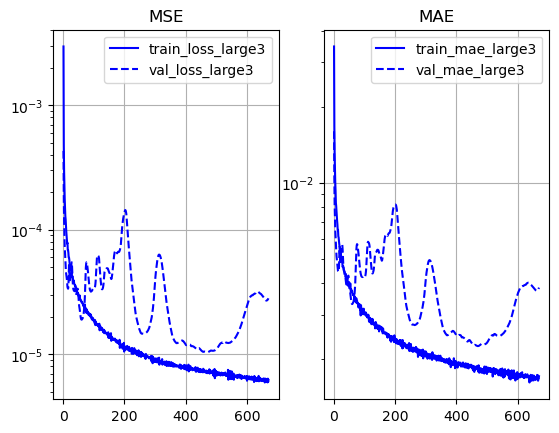

In [318]:
num_epochs_large3 = len(train_losses_large3)

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_large3+1), train_losses_large3, label="train_loss_large3", color='blue')
plt.plot(range(1, num_epochs_large3+1), val_losses_large3, label="val_loss_large3", color='blue', linestyle='--')

plt.title("MSE")
plt.yscale('log')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_large3+1), train_maes_large3, label="train_mae_large3", color='blue')
plt.plot(range(1, num_epochs_large3+1), val_maes_large3, label="val_mae_large3", color='blue', linestyle='--')

plt.title("MAE")
plt.yscale('log')
plt.grid(True)
plt.legend()

plt.show()

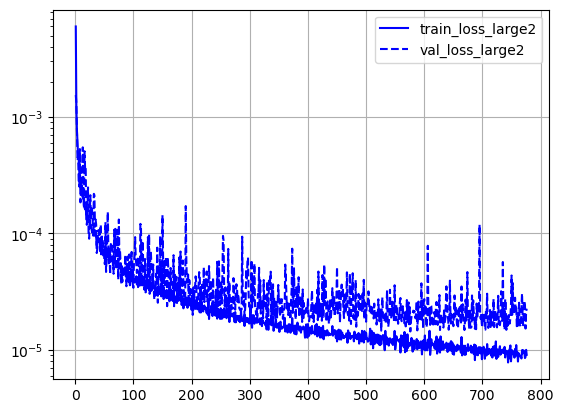

In [174]:
num_epochs_large2 = len(train_losses_large2)

plt.plot(range(1, num_epochs_large2+1), train_losses_large2, label="train_loss_large2", color='blue')
plt.plot(range(1, num_epochs_large2+1), val_losses_large2, label="val_loss_large2", color='blue', linestyle='--')

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

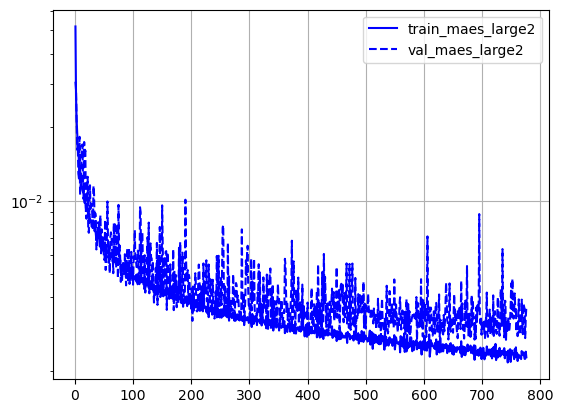

In [175]:
num_epochs_large2 = len(train_losses_large2)

plt.plot(range(1, num_epochs_large2+1), train_maes_large2, label="train_maes_large2", color='blue')
plt.plot(range(1, num_epochs_large2+1), val_maes_large2, label="val_maes_large2", color='blue', linestyle='--')

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

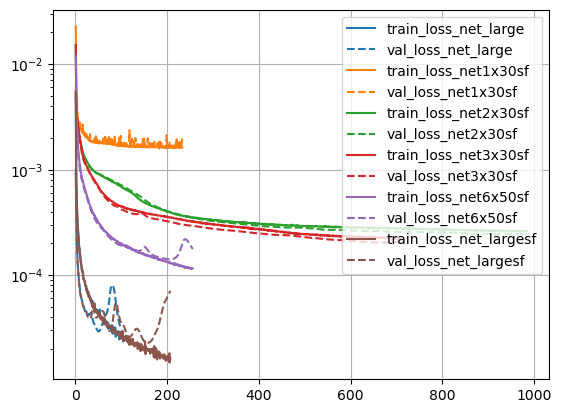

In [169]:
netnames = ['net_large', 'net1x30sf', 'net2x30sf', 'net3x30sf', 'net6x50sf', 'net_largesf']
for i, (netname, tl, vl) in enumerate(zip(netnames, train_losses_list, val_losses_list)):
    num_epochs = len(tl)
    color = f"C{i}"
    plt.plot(range(1, num_epochs+1), tl, label=f"train_loss_{netname}", color=color)
    plt.plot(range(1, num_epochs+1), vl, label=f"val_loss_{netname}", color=color, linestyle='--')


plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

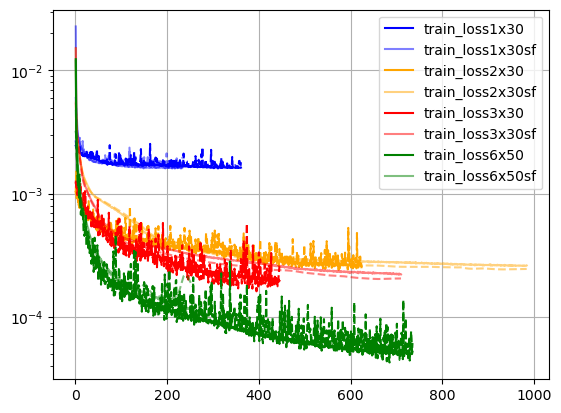

In [197]:
num_epochs1x30 = len(train_losses1x30)
num_epochs2x30 = len(train_losses2x30)
num_epochs3x30 = len(train_losses3x30)
num_epochs6x50 = len(train_losses6x50)

num_epochs1x30sf = len(train_losses_list[1])
num_epochs2x30sf = len(train_losses_list[2])
num_epochs3x30sf = len(train_losses_list[3])
num_epochs6x50sf = len(train_losses_list[4])

plt.plot(range(1, num_epochs1x30+1), train_losses1x30, label="train_loss1x30", color='blue')
plt.plot(range(1, num_epochs1x30+1), val_losses1x30, color='blue', linestyle='--')
plt.plot(range(1, num_epochs1x30sf+1), train_losses_list[1], label="train_loss1x30sf", color='blue', alpha=0.5)
plt.plot(range(1, num_epochs1x30sf+1), val_losses_list[1], color='blue', linestyle='--', alpha=0.5)

plt.plot(range(1, num_epochs2x30+1), train_losses2x30, label="train_loss2x30", color='orange')
plt.plot(range(1, num_epochs2x30+1), val_losses2x30, color='orange', linestyle='--')
plt.plot(range(1, num_epochs2x30sf+1), train_losses_list[2], label="train_loss2x30sf", color='orange', alpha=0.5)
plt.plot(range(1, num_epochs2x30sf+1), val_losses_list[2], color='orange', linestyle='--', alpha=0.5)

plt.plot(range(1, num_epochs3x30+1), train_losses3x30, label="train_loss3x30", color='red')
plt.plot(range(1, num_epochs3x30+1), val_losses3x30, color='red', linestyle='--')
plt.plot(range(1, num_epochs3x30sf+1), train_losses_list[3], label="train_loss3x30sf", color='red', alpha=0.5)
plt.plot(range(1, num_epochs3x30sf+1), val_losses_list[3], color='red', linestyle='--', alpha=0.5)

plt.plot(range(1, num_epochs6x50+1), train_losses6x50, label="train_loss6x50", color='green')
plt.plot(range(1, num_epochs6x50+1), val_losses6x50, color='green', linestyle='--')
plt.plot(range(1, num_epochs6x50sf+1), train_losses_list[4], label="train_loss6x50sf", color='green', alpha=0.5)
plt.plot(range(1, num_epochs6x50sf+1), val_losses_list[4], color='green', linestyle='--', alpha=0.5)

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

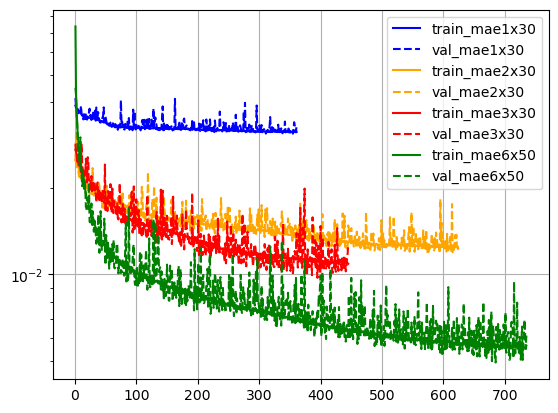

In [154]:
plt.plot(range(1, num_epochs1x30+1), train_maes1x30, label="train_mae1x30", color='blue')
plt.plot(range(1, num_epochs1x30+1), val_maes1x30, label="val_mae1x30", color='blue', linestyle='--')

plt.plot(range(1, num_epochs2x30+1), train_maes2x30, label="train_mae2x30", color='orange')
plt.plot(range(1, num_epochs2x30+1), val_maes2x30, label="val_mae2x30", color='orange', linestyle='--')

plt.plot(range(1, num_epochs3x30+1), train_maes3x30, label="train_mae3x30", color='red')
plt.plot(range(1, num_epochs3x30+1), val_maes3x30, label="val_mae3x30", color='red', linestyle='--')

plt.plot(range(1, num_epochs6x50+1), train_maes6x50, label="train_mae6x50", color='green')
plt.plot(range(1, num_epochs6x50+1), val_maes6x50, label="val_mae6x50", color='green', linestyle='--')

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

## Network Parameter Analysis

In [8]:
ds_train = torch.load('./datasets/maxpool2x2_train_100k_sorted.pth')
ds_val = torch.load('./datasets/maxpool2x2_val_100k_sorted.pth')

In [9]:
def make_net(layer_sizes):
    """
    args:
        layer_sizes - layer sizes without input layer, but with output layer
    """
    layers = [nn.Flatten(), nn.Linear(3*2*2, layer_sizes[0])]
    for ls_prev, ls in zip(layer_sizes[:-1], layer_sizes[1:]):
        layers.append(nn.ReLU())
        layers.append(nn.Linear(ls_prev, ls))

    return torch.nn.Sequential(*layers)

In [11]:
train_results = []
for n_layers in [1, 2, 3, 4]:
    for n_neurons in [10, 20, 30, 40]:
        for batch_size in [16, 32, 64]:
            print(f"n_layers = {n_layers}, n_neurons = {n_neurons}, batch_size = {batch_size}")
            train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(ds_val, batch_size=batch_size)

            net = make_net([n_neurons for i in range(n_layers)] + [1])
            train_losses, val_losses, train_maes, val_maes, best_state = train_loop(net, train_dataloader, val_dataloader, patience=200, num_epochs=200, opt='schedulefree')
            train_result = {'train_losses': train_losses, 'val_losses': val_losses, 'train_maes': train_maes, 'val_maes': val_maes, 'best_state': best_state}
            train_results.append(train_result)

n_layers = 1, n_neurons = 10, batch_size = 16
Epoch [1/200] - train_loss: 0.0381, val_loss: 0.0197, train_mae: 0.1470, val_mae: 0.1104
Epoch [2/200] - train_loss: 0.0129, val_loss: 0.0091, train_mae: 0.0884, val_mae: 0.0751
Epoch [3/200] - train_loss: 0.0082, val_loss: 0.0075, train_mae: 0.0717, val_mae: 0.0684
Epoch [4/200] - train_loss: 0.0074, val_loss: 0.0068, train_mae: 0.0681, val_mae: 0.0652
Epoch [5/200] - train_loss: 0.0071, val_loss: 0.0065, train_mae: 0.0664, val_mae: 0.0636
Epoch [6/200] - train_loss: 0.0069, val_loss: 0.0064, train_mae: 0.0656, val_mae: 0.0632
Epoch [7/200] - train_loss: 0.0068, val_loss: 0.0064, train_mae: 0.0651, val_mae: 0.0631
Epoch [8/200] - train_loss: 0.0067, val_loss: 0.0064, train_mae: 0.0647, val_mae: 0.0630
Epoch [9/200] - train_loss: 0.0067, val_loss: 0.0063, train_mae: 0.0643, val_mae: 0.0627
Epoch [10/200] - train_loss: 0.0065, val_loss: 0.0062, train_mae: 0.0637, val_mae: 0.0623
Epoch [11/200] - train_loss: 0.0064, val_loss: 0.0061, train_ma

In [15]:
cnt = 0
for n_layers in [1, 2, 3, 4]:
    for n_neurons in [10, 20, 30, 40]:
        for batch_size in [16, 32, 64]:
            train_result = train_results[cnt]
            train_result['n_layers'] = n_layers
            train_result['n_neurons'] = n_neurons
            train_result['batch_size'] = batch_size
            cnt += 1

In [21]:
df_train_results = pd.DataFrame(train_results)

df_train_results['min_train_loss'] = df_train_results['train_losses'].apply(lambda x: np.min(x))
df_train_results['min_val_loss'] = df_train_results['val_losses'].apply(lambda x: np.min(x))
df_train_results['min_train_maes'] = df_train_results['train_maes'].apply(lambda x: np.min(x))
df_train_results['min_val_maes'] = df_train_results['val_maes'].apply(lambda x: np.min(x))

df_train_results.head()

train_losses  \
0  [0.03813049159556627, 0.012867166741490363, 0....   
1  [0.03215247862069598, 0.009257396589249602, 0....   
2  [0.05567387240888822, 0.02444542578095213, 0.0...   
3  [0.027931054434254764, 0.00805516076810658, 0....   
4  [0.021973120933190055, 0.006648089838591395, 0...   

                                          val_losses  \
0  [0.019698520467732662, 0.009149197819300544, 0...   
1  [0.01248947315653608, 0.007913913576312031, 0....   
2  [0.027820542879119704, 0.02292196529245452, 0....   
3  [0.011926355709235508, 0.006939710060598704, 0...   
4  [0.007644687332865444, 0.006069595078718226, 0...   

                                          train_maes  \
0  [0.14703967960119246, 0.08842056633353233, 0.0...   
1  [0.13330617508423764, 0.07576038964183301, 0.0...   
2  [0.18218925467613714, 0.12389991573436791, 0.1...   
3  [0.12665291763544081, 0.0706212953966856, 0.06...   
4  [0.10698673842916943, 0.06441323565210735, 0.0...   

                                            val_maes  \
0  [0.11038380648238591, 0.07512234208492426, 0.0...   
1  [0.08789208267999303, 0.07030042286985999, 0.0...   
2  [0.13216562531416928, 0.11919404934101467, 0.1...   
3  [0.08547012974469426, 0.0654725104856034, 0.06...   
4  [0.06895640062963128, 0.06127295040400924, 0.0...   

                                          best_state  n_layers  n_neurons  \
0  {'1.weight': [[tensor(0.5136), tensor(0.5445),...         1         10   
1  {'1.weight': [[tensor(0.2510), tensor(0.2668),...         1         10   
2  {'1.weight': [[tensor(2.3821), tensor(-0.3163)...         1         10   
3  {'1.weight': [[tensor(0.1181), tensor(0.0066),...         1         20   
4  {'1.weight': [[tensor(2.0503), tensor(-0.4280)...         1         20   

   batch_size  min_train_loss  min_val_loss  min_train_maes  min_val_maes  
0          16        0.004651      0.004571        0.053806      0.053352  
1          32        0.005855      0.005711        0.060808      0.059981  
2          64        0.006534      0.006754        0.063547      0.064037  
3          16        0.002876      0.002866        0.042184      0.042115  
4          32        0.002164      0.002241        0.036606      0.037097

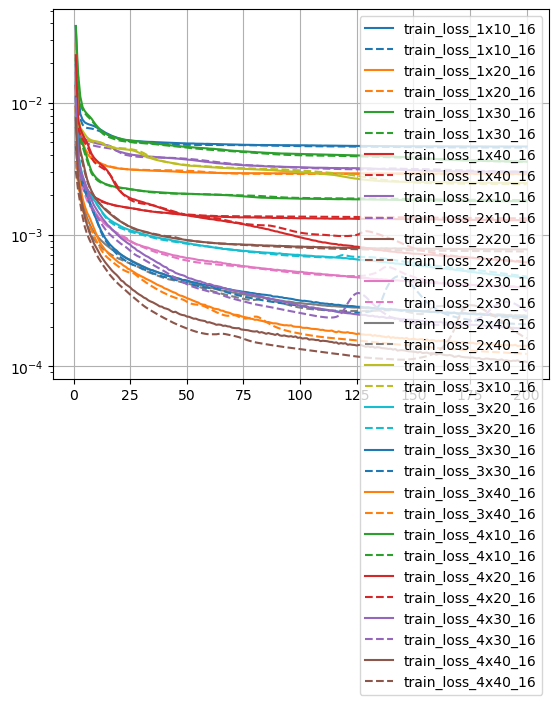

In [34]:
df_plot = df_train_results[df_train_results['batch_size'] == 16]
for i in range(len(df_plot)):
    color = f"C{i}"
    row = df_plot.iloc[i]
    tl = row['train_losses']
    vl = row['val_losses']
    num_epochs = len(tl)
    plt.plot(range(1, num_epochs+1), tl, label=f"train_loss_{row['n_layers']}x{row['n_neurons']}_{row['batch_size']}", color=color)
    plt.plot(range(1, num_epochs+1), vl, label=f"train_loss_{row['n_layers']}x{row['n_neurons']}_{row['batch_size']}", color=color, linestyle='--')
    
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
df_train_results.to_pickle('df_hyperparams_results.pkl')

# Error Histograms

In [188]:
"""
Computes the difference y_true - y_hat for every sample in the given dataset

args:
    net - neural network
    dloader - data loader for the dataset
"""
def loss_histogram_data(net, dloader):
    all_diffs = []
    with torch.no_grad():
        for batch_X, batch_y in dloader:
            y_hat = net(batch_X)
            all_diffs.append(batch_y - y_hat)

    all_diffs = torch.cat(all_diffs).view(-1).numpy()
    return all_diffs

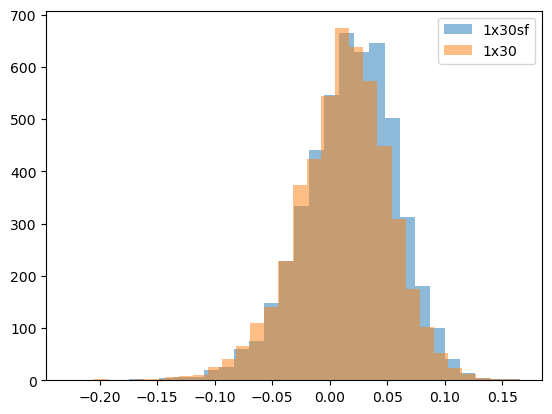

In [215]:
net1x30_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net1x30_best.load_state_dict(best_state1x30)

net1x30sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net1x30sf_best.load_state_dict(best_states_list[1])

diffs_1x30sf = loss_histogram_data(net1x30sf_best, val_dataloader)
diffs_1x30   = loss_histogram_data(net1x30_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_1x30sf, bins=n_bins, label="1x30sf", alpha=0.5)
plt.hist(diffs_1x30, bins=n_bins, label='1x30', alpha=0.5)
plt.legend()
plt.show()

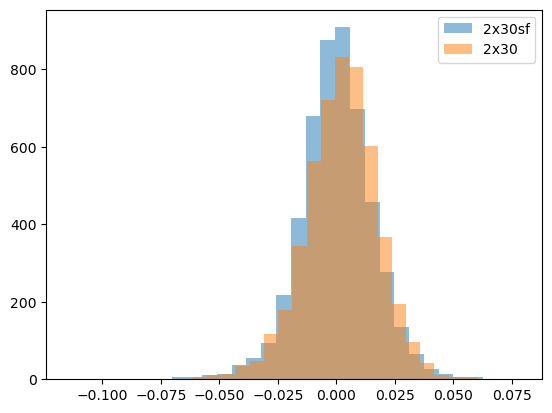

In [205]:
net2x30_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30_best.load_state_dict(best_state2x30)

net2x30sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30sf_best.load_state_dict(best_states_list[2])

diffs_2x30sf = loss_histogram_data(net2x30sf_best, val_dataloader)
diffs_2x30   = loss_histogram_data(net2x30_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_2x30sf, bins=n_bins, label="2x30sf", alpha=0.5)
plt.hist(diffs_2x30, bins=n_bins, label='2x30', alpha=0.5)
plt.legend()
plt.show()

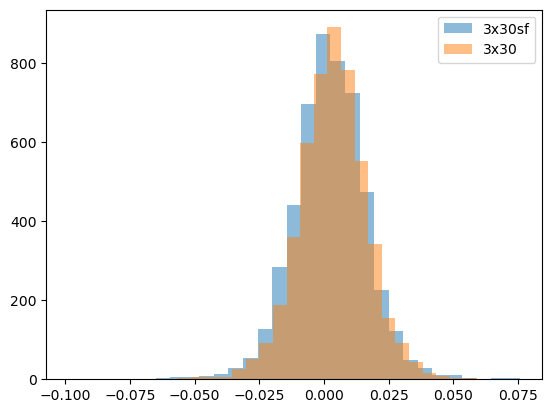

In [207]:
net3x30_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(),  torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30_best.load_state_dict(best_state3x30)

net3x30sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(),  torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30sf_best.load_state_dict(best_states_list[3])

diffs_3x30sf = loss_histogram_data(net3x30sf_best, val_dataloader)
diffs_3x30   = loss_histogram_data(net3x30_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_3x30sf, bins=n_bins, label="3x30sf", alpha=0.5)
plt.hist(diffs_3x30, bins=n_bins, label='3x30', alpha=0.5)
plt.legend()
plt.show()

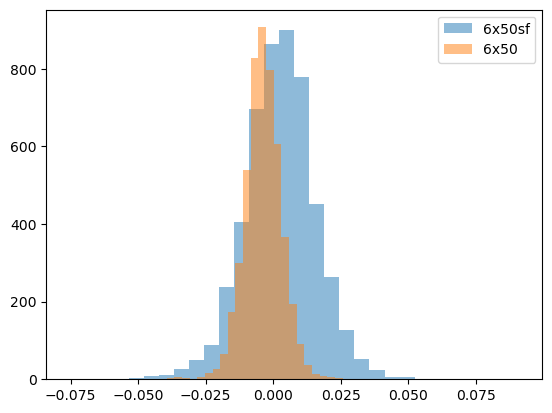

In [208]:
net6x50_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net6x50_best.load_state_dict(best_state6x50)

net6x50sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net6x50sf_best.load_state_dict(best_states_list[4])

diffs_6x50sf = loss_histogram_data(net6x50sf_best, val_dataloader)
diffs_6x50   = loss_histogram_data(net6x50_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_6x50sf, bins=n_bins, label="6x50sf", alpha=0.5)
plt.hist(diffs_6x50, bins=n_bins, label='6x50', alpha=0.5)
plt.legend()
plt.show()

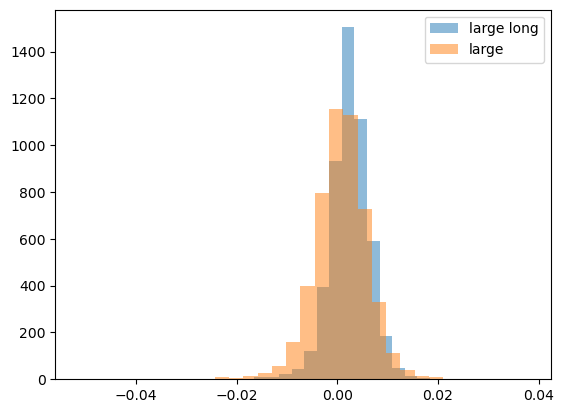

In [209]:
net_large_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))
net_large_best.load_state_dict(best_states_list[0])

net_large_long_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))
net_large_long_best.load_state_dict(best_state_large2)

diffs_large_long = loss_histogram_data(net_large_long_best, val_dataloader)
diffs_large      = loss_histogram_data(net_large_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_large_long, bins=n_bins, label="large long", alpha=0.5)
plt.hist(diffs_large, bins=n_bins, label='large', alpha=0.5)
plt.legend()
plt.show()

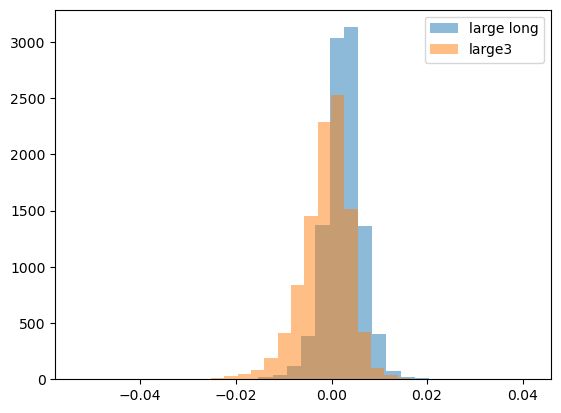

In [319]:
net_large3_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))
net_large3_best.load_state_dict(best_state_large3)

net_large_long_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))
net_large_long_best.load_state_dict(best_state_large2)

diffs_large_long = loss_histogram_data(net_large_long_best, val_dataloader)
diffs_large3      = loss_histogram_data(net_large3_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_large_long, bins=n_bins, label="large long", alpha=0.5)
plt.hist(diffs_large3, bins=n_bins, label='large3', alpha=0.5)
plt.legend()
plt.show()

# Input Format

Each input consists of a $2\times 2$ tensor of `(l, u, alpha)`.

In the first layer of the neural network, this input is flattened.
I.e. we now have a flat array of `[l1, ..., l4, u1, ..., u4, alpha1, ..., alpha4]`.

In [212]:
ds_train[0][0].shape

torch.Size([3, 2, 2])

In [210]:
ds_train[0]

(tensor([[[0.7138, 0.2893],
          [0.5006, 0.1497]],
 
         [[0.9137, 0.3436],
          [0.7011, 0.7816]],
 
         [[0.5361, 0.0492],
          [0.3276, 0.7446]]]),
 tensor([0.1342]))

In [213]:
ds_train[0][0].flatten()

tensor([0.7138, 0.2893, 0.5006, 0.1497, 0.9137, 0.3436, 0.7011, 0.7816, 0.5361,
        0.0492, 0.3276, 0.7446])

# Export to ONNX

In [320]:
dummy_input = torch.randn(1, 3, 2, 2)

models = [net1x30sf_best, net2x30sf_best, net6x50_best]
onnx_files = ['net1x30_best.onnx', 'net2x30_best.onnx', 'net6x50_best.onnx']

for model, filename in zip(models, onnx_files):
    torch.onnx.export(model, dummy_input, './models/' + filename, export_params=True, do_constant_folding=True, opset_version=7, input_names=['X'], output_names=['Y'])


# Different Datasets for Number of Maximum Candidates

We might get better absolute error, if we don't require one neural network to handle cases, where the MaxPool unit is fixed, there are two candidates for the maximum, there are three candidates for the maixmum and there are four candidates for the maximum.
Instead, we can train a dedicated neural network for each of these cases.

The MaxPool neuron is fixed, if $\max_i l_i > \max_{j \neq i} u_j$.

The input with index $i$ can be the maximum, if $\max_j l_j \leq u_i$.

In [270]:
def n_candidates(lower, upper):
    l_max, inds_max = torch.max(lower.flatten(-2), dim=1)
    n_cand = (upper.flatten(-2) >= l_max.unsqueeze(1)).sum(dim=1)
    return n_cand

In [275]:
lower = ds_train[:][0][:,0,:,:]
upper = ds_train[:][0][:,1,:,:]
alpha = ds_train[:][0][:,2,:,:]

n_cand_train = n_candidates(lower, upper)

lower = ds_val[:][0][:,0,:,:]
upper = ds_val[:][0][:,1,:,:]
alpha = ds_val[:][0][:,2,:,:]

n_cand_val = n_candidates(lower, upper)

In [ ]:
print((n_cand_train == 1).sum() / len(n_cand_train))
print((n_cand_train == 2).sum() / len(n_cand_train))
print((n_cand_train == 3).sum() / len(n_cand_train))
print((n_cand_train == 4).sum() / len(n_cand_train))

tensor(0.1424)
tensor(0.2859)
tensor(0.3442)
tensor(0.2274)


In [ ]:
ds_train4 = torch.utils.data.Subset(ds_train, torch.arange(len(ds_train))[n_cand_train == 4])
ds_val4   = torch.utils.data.Subset(ds_val, torch.arange(len(ds_val))[n_cand_val == 4])

print("Train: ", len(ds_train4[0]))
print("Val:   ", len(ds_val4[0]))

train_dataloader4 = DataLoader(ds_train4, batch_size=batch_size, shuffle=True)
val_dataloader4 = DataLoader(ds_val4, batch_size=batch_size)

Train:  11372
Val:    1139


In [305]:
net1x30_4 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30_4 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30_4 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net6x50_4 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))

In [306]:
nets4 = [net1x30_4, net2x30_4, net3x30_4, net6x50_4]

train_losses4_list = []
val_losses4_list = []
train_maes4_list = []
val_maes4_list = []
best_states4_list = []

for i, net in enumerate(nets4):
    print("\nStart training of network ", i)
    opt = 'schedulefree'

    train_losses, val_losses, train_maes, val_maes, best_state = train_loop(net, train_dataloader4, val_dataloader4, patience=50, num_epochs=1000, opt=opt)
    train_losses4_list.append(train_losses)
    val_losses4_list.append(val_losses)
    train_maes4_list.append(train_maes)
    val_maes4_list.append(val_maes)
    best_states4_list.append(best_state)


Start training of network  0
Epoch [1/1000] - train_loss: 0.0364, val_loss: 0.0158, train_mae: 0.1428, val_mae: 0.0987
Epoch [2/1000] - train_loss: 0.0149, val_loss: 0.0119, train_mae: 0.0959, val_mae: 0.0853
Epoch [3/1000] - train_loss: 0.0106, val_loss: 0.0085, train_mae: 0.0808, val_mae: 0.0727
Epoch [4/1000] - train_loss: 0.0076, val_loss: 0.0063, train_mae: 0.0682, val_mae: 0.0630
Epoch [5/1000] - train_loss: 0.0061, val_loss: 0.0054, train_mae: 0.0614, val_mae: 0.0585
Epoch [6/1000] - train_loss: 0.0054, val_loss: 0.0049, train_mae: 0.0583, val_mae: 0.0558
Epoch [7/1000] - train_loss: 0.0051, val_loss: 0.0047, train_mae: 0.0566, val_mae: 0.0547
Epoch [8/1000] - train_loss: 0.0047, val_loss: 0.0045, train_mae: 0.0546, val_mae: 0.0534
Epoch [9/1000] - train_loss: 0.0044, val_loss: 0.0042, train_mae: 0.0528, val_mae: 0.0518
Epoch [10/1000] - train_loss: 0.0042, val_loss: 0.0040, train_mae: 0.0513, val_mae: 0.0504
Epoch [11/1000] - train_loss: 0.0040, val_loss: 0.0038, train_mae: 0.

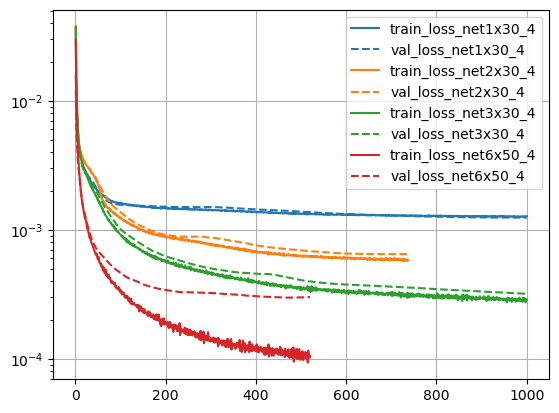

In [308]:
netnames4 = ['net1x30_4', 'net2x30_4', 'net3x30_4', 'net6x50_4']
for i, (netname, tl, vl) in enumerate(zip(netnames4, train_losses4_list, val_losses4_list)):
    num_epochs = len(tl)
    color = f"C{i}"
    plt.plot(range(1, num_epochs+1), tl, label=f"train_loss_{netname}", color=color)
    plt.plot(range(1, num_epochs+1), vl, label=f"val_loss_{netname}", color=color, linestyle='--')


plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

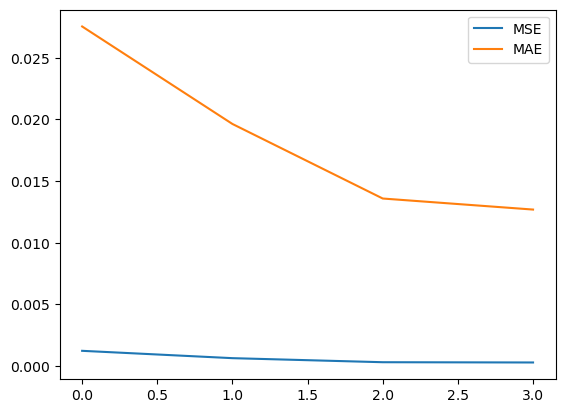

In [312]:
plt.plot([min(tl) for tl in val_losses4_list], label="MSE")
plt.plot([min(tl) for tl in val_maes4_list], label="MAE")

plt.legend()
plt.show()

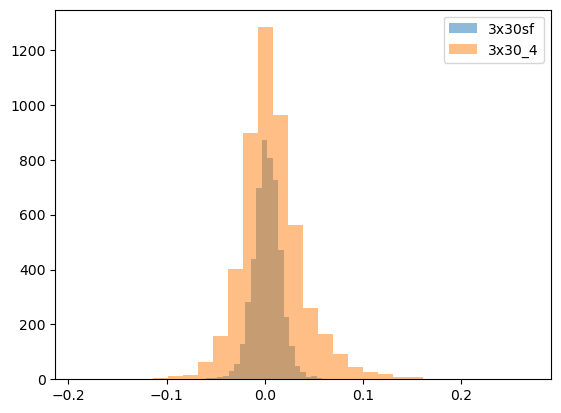

In [313]:
diffs_3x30sf = loss_histogram_data(net3x30sf_best, val_dataloader)
diffs_3x30_4   = loss_histogram_data(net3x30_4,   val_dataloader)

n_bins = 30
plt.hist(diffs_3x30sf, bins=n_bins, label="3x30sf", alpha=0.5)
plt.hist(diffs_3x30_4, bins=n_bins, label='3x30_4', alpha=0.5)
plt.legend()
plt.show()

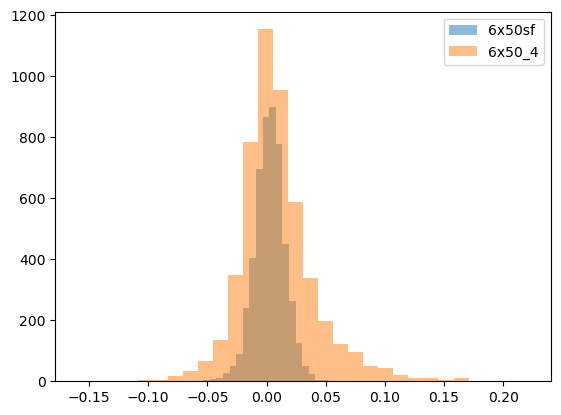

In [314]:
diffs_6x50sf = loss_histogram_data(net6x50sf_best, val_dataloader)
diffs_6x50_4   = loss_histogram_data(net6x50_4,   val_dataloader)

n_bins = 30
plt.hist(diffs_6x50sf, bins=n_bins, label="6x50sf", alpha=0.5)
plt.hist(diffs_6x50_4, bins=n_bins, label='6x50_4', alpha=0.5)
plt.legend()
plt.show()